In [1]:
# Imports

import os
import pandas as pd
import numpy as np
import copy

import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, validation_curve, GridSearchCV, learning_curve
from sklearn.metrics import mean_squared_error,r2_score
from skorch import NeuralNetRegressor
import seaborn as sns

In [2]:
# Load data

# load
df = pd.read_csv("dataf1000.csv")
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df=df.dropna()
del df['time']

# get input variables
X = df[df.columns[0:-3]]

# get output variable
density = df['log_density'] # log based, use 'density' if want density value instead of logged.
perturbation = df['perturbation']

# transform
xscaler = preprocessing.MinMaxScaler()
names = X.columns
d = xscaler.fit_transform(X)
X = pd.DataFrame(d, columns=names)

yscaler = preprocessing.MinMaxScaler()
d = yscaler.fit_transform(perturbation.values.reshape(-1, 1)) # change y accordingly
y = pd.DataFrame(d, columns=['perturbation'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 628)
# Convert to 2D PyTorch tensors
X_train = torch.tensor(X_train.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32).reshape(-1, 1)

In [ ]:
# Optional, skip for multiple run

dataset = df.copy()
_ = sns.pairplot(
    dataset[['mlat', 'cos', 'sin', 'rho', 'ae_index', 'sym_h','density']],
    kind='reg', diag_kind='kde', plot_kws={'scatter_kws': {'alpha': 0.1}})

In [3]:
# Check Device

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# define neural network model
model = nn.Sequential(
    nn.Linear(126, 10),
    nn.ReLU(),
    nn.Linear(10, 20),
    nn.ReLU(),
    nn.Linear(20, 1)
)

# create skorch wrapper for a regressor.
netRegressor = NeuralNetRegressor(
    module=model,
    criterion=nn.MSELoss,
    optimizer=optim.Adam,
    max_epochs=32,
    batch_size=128,
    device=device
)

# Use GridSearchCV to perform hyperparameter tuning
param_grid = {
    'batch_size': [32, 64, 128],
    'criterion': [nn.MSELoss]
}

# uncomment below to parameter tuning

# grid_search = GridSearchCV(estimator=net, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-2)
# print("Best parameters found:", grid_search.best_params_)
# print("Best score:", grid_search.best_score_)

Using cuda device


In [4]:
# Save prediction result
netRegressor.fit(X_train, y_train)
# print(f'model score on testing data: {netRegressor.score(X_test, y_test)}')
y_train_out = netRegressor.predict(X_train)
y_out = netRegressor.predict(X_test)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.0006        0.0001  0.8975
      2        0.0001        0.0001  0.3652
      3        0.0001        0.0001  0.3642
      4        0.0001        0.0001  0.3634
      5        0.0001        0.0001  0.3650
      6        0.0001        0.0001  0.3640
      7        0.0001        0.0001  0.3628
      8        0.0001        0.0001  0.3636
      9        0.0001        0.0001  0.3662
     10        0.0001        0.0001  0.3640
     11        0.0001        0.0001  0.3651
     12        0.0001        0.0001  0.3643
     13        0.0001        0.0001  0.3642
     14        0.0001        0.0001  0.3637
     15        0.0001        0.0001  0.3660
     16        0.0001        0.0001  0.3648
     17        0.0001        0.0001  0.3626
     18        0.0001        0.0001  0.3637
     19        0.0001        0.0001  0.3656
     20        0.0001        0.0001  0.3660
     21        0.0001        0.0

In [7]:
print(r2_score(y_test, y_out))

0.0017509295749630338


In [ ]:
pd.DataFrame(y_train).describe()

In [ ]:
pd.DataFrame(y_train_out).describe()

In [ ]:
pd.DataFrame(y_test).describe()

In [ ]:
dny.reshape() = yscaler.inverse_transform(y_out).flatten()

pd.DataFrame(dny).describe()

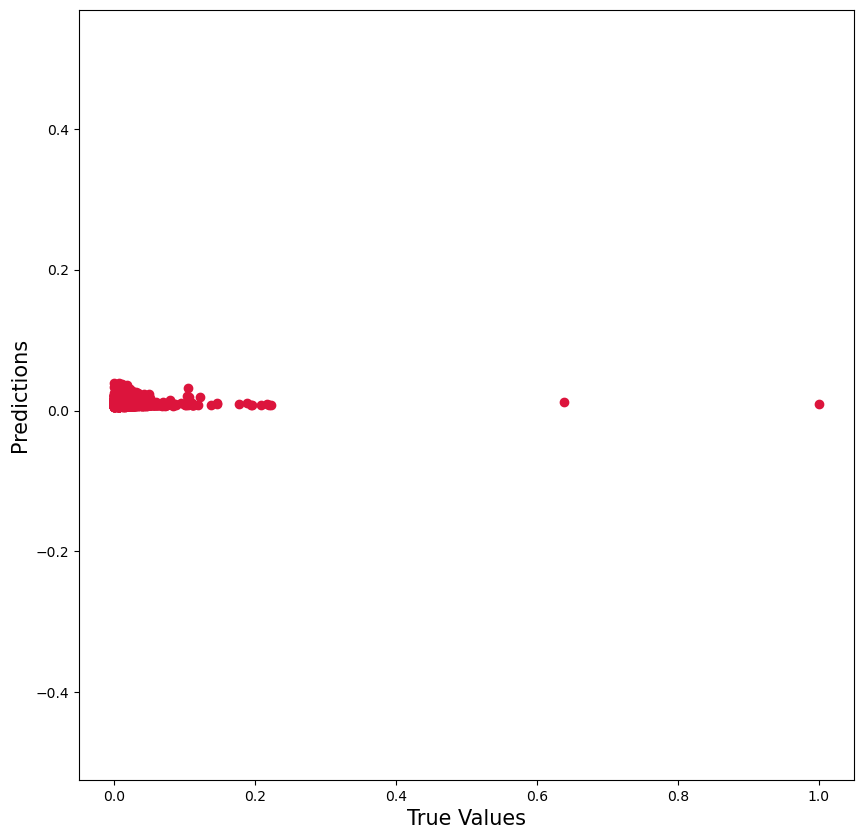

In [8]:
plt.figure(figsize=(10,10))
plt.scatter(y_test.numpy(), y_out, c='crimson')
# plt.yscale('log')
# plt.xscale('log')

# p1 = max(max(dny), max(y_test.numpy()))
# p2 = min(min(dny), min(y_test.numpy()))
# plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

In [ ]:
# full data run

full_df = pd.read_csv("den_data.csv")
full_df.replace([np.inf, -np.inf], np.nan, inplace=True)
full_df=full_df.dropna()

X = full_df[full_df.columns[0:-1]]  #  X will hold all features
#y = df['theta5']/np.pi # y will hold target/labels
y = np.log10(full_df['density'])
scaler = preprocessing.MinMaxScaler()
names = X.columns
d = scaler.fit_transform(X)
X = pd.DataFrame(d, columns=names)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0, random_state = 628)
# Convert to 2D PyTorch tensors
X_train = torch.tensor(X_train.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32).reshape(-1, 1)

X_train.describe()